# HRDE Simple Demo (Colab) — **Same scope as `hrde_simple_demo_qwenfix.zip`**

- (build-index + chat CLI + `detect()` function)
- hybrid retrieval: **FAISS + BM25**
- optional HyDE rerank



---

1) Upload `hrde_simple_demo_qwenfix.zip` to your Google Drive  
2) Unzip it in Colab  
3) Generate `data/reference_docs.jsonl` from **HealthRCN** (1k docs)  
4) Build index  
5) Run chat  
6) Create eval samples + run evaluation metrics + plots

## 1) Mount Drive + point to your ZIP

In [1]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 2) Install demo requirements (from the zip)

In [2]:
import os, textwrap
WORKDIR = DOCS_JSONL = "/content/drive/MyDrive/nlp_project"


REQ = os.path.join(WORKDIR, "requirements.txt")
print("requirements.txt:", REQ)

!pip -q install -U pip
!pip -q install -r "$REQ"

requirements.txt: /content/drive/MyDrive/nlp_project/requirements.txt


# 3) Download Model

In [3]:
from huggingface_hub import snapshot_download
import os

repo_id = "Qwen/Qwen3-4B-Instruct-2507"
target_dir = "/content/Qwen3-4B-Instruct-2507"

snapshot_download(
    repo_id=repo_id,
    local_dir=target_dir,
    local_dir_use_symlinks=False,
    resume_download=True,
    max_workers=4,
)
print("Downloaded to:", target_dir)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_validators.py:186: UserWarning: The `resume_download` argument is deprecated and ignored in `snapshot_download`. Downloads always resume whenever possible.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_validators.py:202: UserWarning: The `local_dir_use_symlinks` argument is deprecated and ignored in `snapshot_download`. Downloading to a local directory does not use symlinks anymore.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.

Fetching 13 files:   0%|          | 0/13 [00:00<?, ?it/s]

Downloaded to: /content/Qwen3-4B-Instruct-2507


## 4) Generate 1,000 reference docs from **HealthRCN** into the demo `data/` folder

This will stream `Hush-cd/HealthRCN` and write:

- `data/reference_docs.jsonl`  (1,000 lines)

Each line schema matches the demo code:
`title`, `text`, `date`, `url`

In [4]:
import os, json, re, unicodedata, time
import requests
from tqdm import tqdm
import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"
OUT_JSONL = os.path.join(WORKDIR, "data", "reference_docs.jsonl")

N_DOCS = 1000
BATCH = 50
SLEEP = 1.2
MAX_RETRY = 6

DATASET_ID = "Hush-cd/HealthRCN"
BASE = "https://datasets-server.huggingface.co"
CONFIG = "default"
SPLIT = "train"

os.makedirs(os.path.dirname(OUT_JSONL), exist_ok=True)

def clean_text(s):
    if s is None:
        return ""
    s = unicodedata.normalize("NFKC", str(s))
    s = re.sub(r"\s+", " ", s).strip()
    return s

def to_ref(row):
    _id = row.get("_id", "")
    title = clean_text(row.get("title")) or clean_text(row.get("content"))[:60]
    parts = []
    for k, lab in [
        ("original_question", "Original question"),
        ("content", "Claim/Content"),
        ("keywords", "Keywords"),
        ("extend_content", "Extended content"),
        ("squash_content", "Refutation/Correction"),
        ("answer_content", "Answer/Explanation"),
    ]:
        v = clean_text(row.get(k))
        if v:
            parts.append(f"{lab}: {v}")
    text = "\n".join(parts).strip()
    return {"title": title, "text": text, "date": "", "url": f"healthrcn:{_id}"}

def fetch_rows(offset, length):
    url = f"{BASE}/rows"
    params = dict(dataset=DATASET_ID, config=CONFIG, split=SPLIT, offset=offset, length=length)

    # optional auth (ONLY if you set HF_TOKEN)
    headers = {}
    token = os.environ.get("HF_TOKEN", "").strip()
    if token:
        headers["Authorization"] = f"Bearer {token}"

    # simple retry loop
    for attempt in range(MAX_RETRY):
        r = requests.get(url, params=params, headers=headers, timeout=60)
        if r.status_code == 200:
            return r.json()
        if r.status_code == 429:
            wait = 2 + attempt * 2
            print(f"429 rate limit → sleep {wait}s")
            time.sleep(wait)
            continue
        # other errors: print & retry a bit
        print("HTTP", r.status_code, r.text[:120])
        time.sleep(2 + attempt)
    raise RuntimeError("Failed too many times. Try increasing SLEEP or reducing N_DOCS.")

# write file
written = 0
offset = 0

with open(OUT_JSONL, "w", encoding="utf-8") as f:
    pbar = tqdm(total=N_DOCS, desc="Writing reference_docs.jsonl")
    while written < N_DOCS:
        js = fetch_rows(offset, BATCH)
        rows = js.get("rows", [])
        if not rows:
            print("No rows returned. Stop.")
            break

        for item in rows:
            row = item.get("row", item)
            obj = to_ref(row)
            if obj["text"]:
                f.write(json.dumps(obj, ensure_ascii=False) + "\n")
                written += 1
                pbar.update(1)
                if written >= N_DOCS:
                    break

        offset += len(rows)
        time.sleep(SLEEP)

    pbar.close()

print("Wrote:", written, "rows →", OUT_JSONL)
!head -n 2 "$OUT_JSONL"


Writing reference_docs.jsonl: 100%|██████████| 1000/1000 [00:34<00:00, 29.18it/s]

Wrote: 1000 rows → /content/drive/MyDrive/nlp_project/data/reference_docs.jsonl
{"title": "痔疮自愈方法大揭秘!", "text": "Original question: 痔疮怎么做可以自己痊愈\nClaim/Content: 据权威机构专家研究,痔疮是一种常见疾病,危害极大。然而,现在,一种独特的自愈方法被发现了!只需每天坐在凉水里泡脚,即可缓解痔疮症状,恢复健康。据数据统计,坚持泡脚的人,95%能够成功自愈!赶快分享给身边的朋友吧,让他们也体验轻松自愈的快感!\nKeywords: 痔疮,自愈,泡脚\nExtended content: 痔疮是一种十分常见的肛肠疾病,是由于静脉曲张引起的直肠或肛门处的静脉血管丧失正常弹性,导致局部疼痛、出血、瘙痒等不良症状。虽然痔疮不是致命疾病,但对生活质量的影响是非常大的。目前,化学药物和手术是治疗痔疮的主要手段,但药物可能存在副作用,并且手术可能带来风险和后遗症。 最近,有一种独特的自愈方法被一些专家推荐,即坐在凉水里泡脚以缓解痔疮症状和促进恢复。泡脚是一种中医疗法,通过将脚浸泡在温水或冷水中以改善身体状况。它的原理是通过足部神经末梢的刺激,可以促进局部血液循环,缓解肌肉疲劳和缓解身体疼痛。泡脚具有温和、舒适、易操作等优点,并且可以适用于许多不同的健康问题。 据数据统计,坚持泡脚的人可以在一定程度上缓解痔疮症状,还可以帮助调节身体机能,增强免疫力,有助于促进身体自愈。虽然泡脚是一种非常安全的自愈方法,但并不适用于所有人。例如,对于存在伤口、循环系统疾病、糖尿病、高血压、心脏病等疾病的人不宜进行泡脚疗法。如果出现过度泡脚、受凉等不良反应,建议及时终止泡脚疗法。 在实施泡脚疗法之前,要选择一个清洁、卫生的环境,并在水中加入适量的盐、草药、精油等调味剂,以发挥泡脚的最佳功效。在泡脚时要尽量保持身体放松,可同时进行其他放松活动,如阅读杂志、听轻松的音乐等。此外,注意泡脚时水温不宜过高,推荐水温在30-35摄氏度之间,泡脚的时间每次不宜过长,一般建议15-30分钟为宜。 总之,泡脚作为一种健康、自然的疗法,可以一定程度上缓解痔疮症状,并有助于身体的自愈和健康维护。但这并不是万能的,对于存在病症或身体状况不佳的人应该在医生的指导下进行,以避免引发

In [5]:
import os

INDEX_DIR = os.path.join(WORKDIR, "index")
DATA_DIR = os.path.join(WORKDIR, 'data')
MODEL_DIR = 'Qwen3-4B-Instruct-2507'
REFERENCE_JSONL = os.path.join(WORKDIR, "data", "reference_docs.jsonl")


## 4) Pipline Code

- `build_index(...)`: builds the retrieval index from `data/reference_docs.jsonl` (FAISS + BM25).
- `detect(...)`: runs the end-to-end pipeline for one claim (retrieve → rerank → final decision).

✅ This cell mostly **defines functions**  
Next sections will **call** these functions to build the index, test chat, and run evaluation.


## 4.1) Imports + data classes

This cell imports required libraries and defines the core data structures used throughout the pipeline:
- `ReferenceDoc` (raw doc)
- `Chunk` (chunked text unit for indexing)
- `RetrievalHit` (retrieval result)


In [6]:
from __future__ import annotations

import argparse
import dataclasses
import json
import re
from dataclasses import dataclass
from pathlib import Path
from typing import Any, Dict, List, Optional

import numpy as np
from tqdm import tqdm

from sentence_transformers import SentenceTransformer
import faiss
from rank_bm25 import BM25Okapi
import jieba


@dataclass
class ReferenceDoc:
    title: str
    text: str
    date: str = ""
    url: str = ""
    source: str = ""

@dataclass
class Chunk:
    chunk_id: str
    doc_id: str
    title: str
    text: str
    date: str
    url: str
    source: str

@dataclass
class RetrievalHit:
    chunk: Chunk
    score: float
    method: str  # "faiss" / "bm25" / "hyde"


## 4.2) Text utilities (tokenization + chunking)

This cell contains:
- basic Chinese detection
- tokenizer (jieba for Chinese, regex for English)
- simple overlapping chunker (character-based)
- cosine similarity helper


In [7]:
def is_chinese(s: str) -> bool:
    return any("\u4e00" <= ch <= "\u9fff" for ch in s)

def tokenize(text: str) -> List[str]:
    text = text.strip()
    if not text:
        return []
    if is_chinese(text):
        return [t for t in jieba.lcut(text) if t.strip()]
    return re.findall(r"[A-Za-z0-9]+", text.lower())

def chunk_text(text: str, max_chars: int = 800, overlap: int = 120) -> List[str]:
    text = re.sub(r"\s+", " ", text.strip())
    if not text:
        return []
    chunks = []
    start = 0
    while start < len(text):
        end = min(len(text), start + max_chars)
        chunk = text[start:end].strip()
        if chunk:
            chunks.append(chunk)
        if end >= len(text):
            break
        start = max(0, end - overlap)
    return chunks

def cosine_sim(a: np.ndarray, b: np.ndarray) -> float:
    denom = (np.linalg.norm(a) * np.linalg.norm(b)) + 1e-12
    return float(np.dot(a, b) / denom)

def safe_mkdir(p: Path) -> None:
    p.mkdir(parents=True, exist_ok=True)


## 4.3) Load reference documents
Reads dataset

Output: a list of `ReferenceDoc`


In [8]:
def read_reference_docs(path: str) -> List[ReferenceDoc]:
    p = Path(path)
    docs: List[ReferenceDoc] = []

    def load_jsonl(fp: Path):
        nonlocal docs
        with fp.open("r", encoding="utf-8") as f:
            for line in f:
                line = line.strip()
                if not line:
                    continue
                obj = json.loads(line)
                docs.append(ReferenceDoc(
                    title=str(obj.get("title","")).strip(),
                    text=str(obj.get("text","")).strip(),
                    date=str(obj.get("date","")).strip(),
                    url=str(obj.get("url","")).strip(),
                    source=str(obj.get("source","")).strip(),
                ))

    def load_csv(fp: Path):
        nonlocal docs
        import pandas as pd
        df = pd.read_csv(fp)
        colmap = {c.lower(): c for c in df.columns}

        def getcol(name: str) -> Optional[str]:
            return colmap.get(name.lower())

        for _, row in df.iterrows():
            title = str(row.get(getcol("title"), "")).strip()
            text = str(row.get(getcol("text"), "")).strip()
            date = str(row.get(getcol("date"), "")).strip()
            url = str(row.get(getcol("url"), "")).strip()
            source = str(row.get(getcol("source"), fp.stem)).strip()
            docs.append(ReferenceDoc(title=title, text=text, date=date, url=url, source=source))

    if p.is_dir():
        for fp in sorted(p.rglob("*")):
            if fp.suffix.lower() == ".jsonl":
                load_jsonl(fp)
            elif fp.suffix.lower() == ".csv":
                load_csv(fp)
    else:
        if p.suffix.lower() == ".jsonl":
            load_jsonl(p)
        elif p.suffix.lower() == ".csv":
            load_csv(p)
        else:
            raise ValueError(f"Unsupported file: {path}")

    docs = [d for d in docs if d.title and d.text]
    return docs


## 4.4) Build the retrieval index (FAISS + BM25)

This converts docs into chunks and builds:
- a FAISS vector index (semantic search)
- a BM25 index (keyword search)

It saves everything into `INDEX_DIR`.


In [9]:
def build_index(
    input_path: str,
    out_dir: str,
    embed_model_name: str = "moka-ai/m3e-base",
    max_chars: int = 800,
    overlap: int = 120,
    batch_size: int = 64,
) -> None:
    outp = Path(out_dir)
    safe_mkdir(outp)

    print(f"[1/4] Loading reference docs from: {input_path}")
    docs = read_reference_docs(input_path)
    print(f"Loaded {len(docs)} documents")

    print(f"[2/4] Chunking docs (max_chars={max_chars}, overlap={overlap})")
    chunks: List[Chunk] = []
    for i, d in enumerate(tqdm(docs, desc="chunking")):
        doc_id = f"doc_{i:07d}"
        for j, ct in enumerate(chunk_text(d.text, max_chars=max_chars, overlap=overlap)):
            chunks.append(Chunk(
                chunk_id=f"{doc_id}_chunk_{j:03d}",
                doc_id=doc_id,
                title=d.title,
                text=ct,
                date=d.date,
                url=d.url,
                source=d.source,
            ))
    print(f"Created {len(chunks)} chunks")

    print(f"[3/4] Embedding chunks with: {embed_model_name}")
    embedder = SentenceTransformer(embed_model_name)
    emb = embedder.encode(
        [c.text for c in chunks],
        batch_size=batch_size,
        show_progress_bar=True,
        normalize_embeddings=True,
    ).astype("float32")
    dim = emb.shape[1]

    print(f"[4/4] Building FAISS + BM25")
    index = faiss.IndexFlatIP(dim)
    index.add(emb)

    tokenized_corpus = [tokenize(c.text) for c in chunks]
    _ = BM25Okapi(tokenized_corpus)

    faiss.write_index(index, str(outp / "faiss.index"))
    with (outp / "chunks.jsonl").open("w", encoding="utf-8") as f:
        for c in chunks:
            f.write(json.dumps(dataclasses.asdict(c), ensure_ascii=False) + "\n")
    with (outp / "bm25.json").open("w", encoding="utf-8") as f:
        json.dump({"tokenized_corpus": tokenized_corpus}, f, ensure_ascii=False)
    with (outp / "meta.json").open("w", encoding="utf-8") as f:
        json.dump({
            "embed_model_name": embed_model_name,
            "dim": dim,
            "num_docs": len(docs),
            "num_chunks": len(chunks),
            "max_chars": max_chars,
            "overlap": overlap,
        }, f, ensure_ascii=False, indent=2)

    print(f"✅ Index saved to: {outp.resolve()}")


## 4.5) Load index + retrieve (FAISS and BM25)

This cell defines `LocalIndex`:
- loads saved FAISS / chunks / BM25 corpus
- runs semantic and keyword retrieval


In [10]:
class LocalIndex:
    def __init__(self, index_dir: str):
        self.dir = Path(index_dir)
        self.index = faiss.read_index(str(self.dir / "faiss.index"))

        self.chunks: List[Chunk] = []
        with (self.dir / "chunks.jsonl").open("r", encoding="utf-8") as f:
            for line in f:
                obj = json.loads(line)
                self.chunks.append(Chunk(**obj))

        with (self.dir / "bm25.json").open("r", encoding="utf-8") as f:
            obj = json.load(f)
        self.tokenized_corpus = obj["tokenized_corpus"]
        self.bm25 = BM25Okapi(self.tokenized_corpus)

        with (self.dir / "meta.json").open("r", encoding="utf-8") as f:
            meta = json.load(f)
        self.embed_model_name = meta["embed_model_name"]
        self.embedder = SentenceTransformer(self.embed_model_name)

    def embed(self, text: str) -> np.ndarray:
        vec = self.embedder.encode([text], normalize_embeddings=True).astype("float32")
        return vec[0]

    def search_faiss(self, query: str, top_n: int = 20) -> List[RetrievalHit]:
        q = self.embed(query).reshape(1, -1)
        scores, idxs = self.index.search(q, top_n)
        hits: List[RetrievalHit] = []
        for score, idx in zip(scores[0].tolist(), idxs[0].tolist()):
            if idx < 0:
                continue
            hits.append(RetrievalHit(chunk=self.chunks[idx], score=float(score), method="faiss"))
        return hits

    def search_bm25(self, query: str, top_n: int = 20) -> List[RetrievalHit]:
        qt = tokenize(query)
        scores = self.bm25.get_scores(qt)
        idxs = np.argsort(scores)[::-1][:top_n]
        hits: List[RetrievalHit] = []
        for idx in idxs:
            hits.append(RetrievalHit(chunk=self.chunks[int(idx)], score=float(scores[int(idx)]), method="bm25"))
        return hits


## 4.6) Local LLM client

Loads a **local HF model** using `transformers`.
pass your model path or Hugging Face model id (e.g. Qwen3 4B).


In [11]:
class LLMClient:
    def __init__(self, model: str):
        from transformers import AutoModelForCausalLM, AutoTokenizer
        import torch

        self.torch = torch
        self.tokenizer = AutoTokenizer.from_pretrained(model, trust_remote_code=True)
        self.local_model = AutoModelForCausalLM.from_pretrained(
            model,
            device_map="auto",
            torch_dtype=torch.float16 if torch.cuda.is_available() else torch.float32,
            trust_remote_code=True,attn_implementation="eager"
        )
        self.local_model.eval()

    def generate(self, system: str, user: str, max_tokens: int = 256, temperature: float = 0.1) -> str:
        messages = [
            {"role": "system", "content": system},
            {"role": "user", "content": user},
        ]
        try:
            text = self.tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
        except Exception:
            text = f"{system}\n\n{user}\n"

        model_inputs = self.tokenizer([text], return_tensors="pt").to(self.local_model.device)

        # ✅ key change: turn OFF sampling when temperature == 0
        do_sample = float(temperature) > 0.0

        gen_kwargs = dict(
            **model_inputs,
            max_new_tokens=max_tokens,
            repetition_penalty=1.05,
            use_cache=True,
        )

        if do_sample:
            gen_kwargs.update(
                do_sample=True,
                temperature=temperature,
                top_p=0.8,
                top_k=10,
            )
        else:
            gen_kwargs.update(
                do_sample=False,  # deterministic
            )

        with self.torch.no_grad():
            generated = self.local_model.generate(**gen_kwargs)

        generated = generated[:, model_inputs["input_ids"].shape[1]:]
        response = self.tokenizer.batch_decode(generated, skip_special_tokens=True)[0]
        return response.strip()



## 4.7) Prompts + HRDE pipeline (retrieve → rerank → final answer)

Defines:
- the main system prompt
- reference-based prompt
- HyDE reranking step
- `detect(...)` end-to-end function


In [12]:
SYSTEM_PROMPT = (
    "You are a careful assistant for Chinese health rumor verification. "
    "You must be transparent when evidence is missing. "
    "Your output is informational only, not medical advice."
)

# ---- NEW: truncate evidence to reduce KV-cache / VRAM ----
MAX_EVID_CHARS = 260  # change to 150-300 if needed

def _clip(s: str, n: int = MAX_EVID_CHARS) -> str:
    s = (s or "").strip()
    return s if len(s) <= n else (s[:n].rstrip() + "…")


def build_prompt_with_refs(claim: str, hits: List[RetrievalHit]) -> str:
    refs = []
    for i, h in enumerate(hits, start=1):
        refs.append(
            f"[{i}] Title: {h.chunk.title}\n"
            f"Source: {h.chunk.source}\n"
            f"Date: {h.chunk.date}\n"
            f"URL: {h.chunk.url}\n"
            f"Excerpt: {_clip(h.chunk.text, MAX_EVID_CHARS)}\n"
        )
    refs_text = "\n".join(refs)

    return f"""\
[Rumor Detection Task with References]
Input health information:
{claim}

Reference documents:
{refs_text}

Requirements:
1) Decide whether the input is a health rumor.
2) Use only the references above when possible. If evidence is insufficient, say so clearly.
3) Cite references like [1], [2] inside your analysis.
4) Keep the conclusion concise and categorical.

Output format:
[Conclusion] Rumor / Not Rumor / Not Sure
[Analysis] your reasoning with citations
"""


def build_prompt_no_refs(claim: str) -> str:
    return f"""\
[Rumor Detection Task]
Input health information:
{claim}

Requirements:
1) Decide whether the input is a health rumor.
2) If you are not sure, output "Not Sure" and explain what evidence is missing.
3) Do NOT invent sources.

Output format:
[Conclusion] Rumor / Not Rumor / Not Sure
[Analysis] your reasoning
"""


def build_hyde_prompt(claim: str) -> str:
    return f"""\
Write a short factual explanation (150-250 Chinese characters if possible) that would help verify the following health statement.
Do not cite sources. Do not add disclaimers. Just write the content.

Statement:
{claim}
"""


def rerank_with_hyde(
    idx: LocalIndex,
    llm: LLMClient,
    claim: str,
    candidates: List[RetrievalHit],
    top_k: int = 5,
    similarity_threshold: float = 0.3,
) -> List[RetrievalHit]:
    hypo = llm.generate(
        system="You write helpful factual notes for retrieval.",
        user=build_hyde_prompt(claim),
        max_tokens=256,
        temperature=0.1,
    )
    hypo_vec = idx.embed(hypo)

    reranked: List[RetrievalHit] = []
    for h in candidates:
        c_vec = idx.embed(h.chunk.text)
        sim = cosine_sim(hypo_vec, c_vec)
        if sim >= similarity_threshold:
            reranked.append(RetrievalHit(chunk=h.chunk, score=sim, method="hyde"))

    reranked.sort(key=lambda x: x.score, reverse=True)
    return reranked[:top_k]


def merge_hits(*hit_lists: List[RetrievalHit], max_n: int = 50) -> List[RetrievalHit]:
    seen = set()
    merged: List[RetrievalHit] = []
    for hits in hit_lists:
        for h in hits:
            if h.chunk.chunk_id in seen:
                continue
            seen.add(h.chunk.chunk_id)
            merged.append(h)
            if len(merged) >= max_n:
                return merged
    return merged


def detect(
    index_dir: str,
    claim: str,
    local_model: str,
    idx=None,
    llm=None,
    top_n_faiss: int = 12,
    top_n_bm25: int = 12,
    final_k: int = 6,
    use_hyde: bool = False,
    similarity_threshold: float = 0.3,
):
    idx = idx or LocalIndex(index_dir)
    llm = llm or LLMClient(model=local_model)

    faiss_hits = idx.search_faiss(claim, top_n=top_n_faiss)
    bm25_hits  = idx.search_bm25(claim, top_n=top_n_bm25)
    candidates = merge_hits(faiss_hits, bm25_hits, max_n=60)

    # ✅ choose final hits (HyDE optional)
    if use_hyde and candidates:
        final_hits = rerank_with_hyde(
            idx=idx,
            llm=llm,
            claim=claim,
            candidates=candidates,
            top_k=min(final_k, 5),
            similarity_threshold=similarity_threshold,
        )
        if not final_hits:
            final_hits = candidates[:final_k]
    else:
        final_hits = candidates[:final_k]

    prompt = build_prompt_with_refs(claim, final_hits) if final_hits else build_prompt_no_refs(claim)

    answer = llm.generate(
        SYSTEM_PROMPT,
        prompt,
        max_tokens=512,
        temperature=0.1,
    )

    return {
        "claim": claim,
        "raw_answer": answer,
        "references": [
            {"n": i+1, **dataclasses.asdict(h.chunk), "score": h.score, "method": h.method}
            for i, h in enumerate(final_hits)
        ],
    }


## 5) Build the retrieval index (FAISS + BM25)

This cell builds the retrieval index from `data/reference_docs.jsonl`:

- The embedding model converts each text chunk into a vector.
- FAISS enables **semantic search** (vector similarity).
- BM25 enables **keyword search** (token-based).

use `moka-ai/m3e-base`


In [13]:
EMBED_MODEL = 'moka-ai/m3e-base'  # switch to moka-ai/m3e-base for faster

build_index(
    input_path=REFERENCE_JSONL,
    out_dir=INDEX_DIR,
    embed_model_name=EMBED_MODEL,
    max_chars=800,
    overlap=120,
    batch_size=64,
)

print('Index built at:', INDEX_DIR)


[1/4] Loading reference docs from: /content/drive/MyDrive/nlp_project/data/reference_docs.jsonl
Loaded 1000 documents
[2/4] Chunking docs (max_chars=800, overlap=120)


chunking: 100%|██████████| 1000/1000 [00:00<00:00, 16833.51it/s]

Created 3032 chunks
[3/4] Embedding chunks with: moka-ai/m3e-base


Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

BertModel LOAD REPORT from: moka-ai/m3e-base
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Batches:   0%|          | 0/48 [00:00<?, ?it/s]

Building prefix dict from the default dictionary ...
DEBUG:jieba:Building prefix dict from the default dictionary ...
Loading model from cache /tmp/jieba.cache
DEBUG:jieba:Loading model from cache /tmp/jieba.cache


[4/4] Building FAISS + BM25


Loading model cost 0.826 seconds.
DEBUG:jieba:Loading model cost 0.826 seconds.
Prefix dict has been built successfully.
DEBUG:jieba:Prefix dict has been built successfully.


✅ Index saved to: /content/drive/MyDrive/nlp_project/index
Index built at: /content/drive/MyDrive/nlp_project/index


## 6) Live demo: claim → verdict

In this cell we run the end-to-end system on user input:
1. Retrieve top evidence chunks (FAISS + BM25)
2. (Optional) HyDE reranking
3. Generate the final decision using the local LLM

**Tip:** if press enter in each Claim, this live setion will stop


In [14]:
import gc, torch
# example input 维生素C可以治愈感冒。 , 抗生素对细菌感染有效，但对病毒无效。
# --- cache once (DO THIS ONE TIME before the loop) ---
IDX = LocalIndex(INDEX_DIR)
LLM = LLMClient(MODEL_DIR)

USE_HYDE = True  # True if you want HyDE reranking (slower)

print("Type your claim (empty line to exit).")
while True:
    claim = input("Claim> ").strip()
    if not claim:
        break

    # ✅ no_grad reduces memory use for inference
    with torch.no_grad():
        out = detect(
            index_dir=INDEX_DIR,
            claim=claim,
            local_model=MODEL_DIR,
            idx=IDX,
            llm=LLM,
            top_n_faiss=10,
            top_n_bm25=10,
            final_k=5,
            use_hyde=USE_HYDE,
            similarity_threshold=0.3,
        )

    print("\n=== OUTPUT ===")
    print(out["raw_answer"])
    print("==============\n")
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()



Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

BertModel LOAD REPORT from: moka-ai/m3e-base
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
`torch_dtype` is deprecated! Use `dtype` instead!


Loading weights:   0%|          | 0/398 [00:00<?, ?it/s]

Type your claim (empty line to exit).

=== OUTPUT ===
[Conclusion] Rumor  
[Analysis] The input statement "维生素C可以治愈感冒" (Vitamin C can cure colds) is a health rumor. While reference [1] mentions that adequate vitamin C intake can help boost immunity and may alleviate symptoms like nasal congestion and headaches, it explicitly states that "this view is an incorrect one and cannot solve all nasal congestion and headache problems" and emphasizes that vitamin C does not cure colds. Reference [3] also notes that colds are self-limiting and typically resolve within days to weeks, with treatment focusing on symptom relief and immune support rather than a specific "cure." There is no reference supporting that vitamin C cures or treats the underlying viral cause of colds. Therefore, based on available evidence, the claim exceeds scientific support and misrepresents the role of vitamin C in treating colds. [1]


=== OUTPUT ===
[Conclusion] Not Rumor  
[Analysis] The input statement "抗生素对细菌感染有效，但对

## 7.1) Evaluation overview

In this section we evaluate the HRDE pipeline on a labeled test set generated from dataset.

Steps:
1) Generate `data/eval_samples.jsonl` from `data/reference_docs.jsonl`
2) Run detection on each eval claim
3) Compute metrics: valid_rate, accuracy, F1
4) (Optional) compute paper metrics: Relevance / Reliability / Richness (RRR) using a local judge model
5) Plot results and save outputs to `eval/`
### Generate evaluation samples from  dataset
Labels:
- Rumor (1): from `Claim/Content`
- Not Rumor (0): from `Answer/Explanation`


In [24]:
import os, json, re, random
from tqdm.auto import tqdm

REFERENCE_JSONL = os.path.join(DATA_DIR, "reference_docs.jsonl")
EVAL_JSONL      = os.path.join(DATA_DIR, "eval_samples.jsonl")
EVAL_DIR        = os.path.join(WORKDIR, "eval")
os.makedirs(EVAL_DIR, exist_ok=True)

# ---- CONFIG ----
N_RUMOR = 100         # label 1
N_NOT_RUMOR = 100      # label 0
MAX_LEN = 200          # keep claims short for fast eval
SEED = 42
REGEN_EVAL = False    # set True to regenerate even if file exists

random.seed(SEED)

def _clip(s: str, n: int) -> str:
    s = (s or "").strip()
    return s if len(s) <= n else s[:n].strip()

def parse_refdoc_sections(text: str) -> dict:
    """
    reference_docs.jsonl was created with lines like:
      Claim/Content: ...
      Refutation/Correction: ...
      Answer/Explanation: ...
    This parses them into a dict.
    """
    sec = {}
    for line in (text or "").splitlines():
        if ":" in line:
            k, v = line.split(":", 1)
            sec[k.strip()] = v.strip()
    return sec

def generate_eval_from_reference(reference_jsonl: str, out_eval_jsonl: str,
                                n_rumor: int, n_not: int, max_len: int):
    rumor_pool = []
    not_pool = []

    with open(reference_jsonl, "r", encoding="utf-8") as f:
        for line in f:
            obj = json.loads(line)
            sec = parse_refdoc_sections(obj.get("text", ""))

            # Rumor claim (label=1): use Claim/Content if exists
            c = sec.get("Claim/Content", "")
            c = _clip(c, max_len)
            if c:
                rumor_pool.append({"claim": c, "gold_label": 1})

            # Not-rumor (label=0): use Answer/Explanation OR Refutation/Correction (first short chunk)
            a = sec.get("Answer/Explanation", "") or sec.get("Refutation/Correction", "")
            a = _clip(a, max_len)
            if a:
                not_pool.append({"claim": a, "gold_label": 0})

    if len(rumor_pool) == 0 or len(not_pool) == 0:
        raise RuntimeError(
            "Could not build eval pools from reference_docs.jsonl. "
            "Check that your reference docs contain 'Claim/Content' and 'Answer/Explanation' sections."
        )

    random.shuffle(rumor_pool)
    random.shuffle(not_pool)

    samples = rumor_pool[:n_rumor] + not_pool[:n_not]
    random.shuffle(samples)

    with open(out_eval_jsonl, "w", encoding="utf-8") as f:
        for s in samples:
            f.write(json.dumps(s, ensure_ascii=False) + "\n")

    return samples

# Create eval samples if needed
samples = generate_eval_from_reference(
        reference_jsonl=REFERENCE_JSONL,
        out_eval_jsonl=EVAL_JSONL,
        n_rumor=N_RUMOR,
        n_not=N_NOT_RUMOR,
        max_len=MAX_LEN,)


# Load eval lines
with open(EVAL_JSONL, "r", encoding="utf-8") as f:
    eval_lines = f.read().strip().splitlines()

print("Total eval samples:", len(eval_lines))  # should be N_RUMOR + N_NOT_RUMOR

# Show 3 examples
for i in range(min(3, len(eval_lines))):
    print(json.loads(eval_lines[i]))


Total eval samples: 200
{'claim': '腐竹是一种常见的食材,广泛应用于中华厨房中的各种菜肴。然而,有关腐竹是否含有黄体酮以及是否可以食用的问题备受争议。本文将就此问题进行探讨。 首先,黄体酮是一种人体内重要的激素物质。在女性身体中,黄体酮的主要作用是对卵巢和子宫具有重要的调节作用,对于维持正常的生殖健康非常关键。此外,黄体酮在调节女性内分泌水平方面也扮演着非常重要的角色,因此是非常重要的激素物质。 然而,对于腐竹是否含有黄体酮,目前没', 'gold_label': 0}
{'claim': '白木耳是一种常见的食用菌,具有营养丰富、清热润燥等功效,被誉为“山珍海味”。但是,对于很多人来说,白木耳的吃法还不是很清楚,不知道怎样吃能够让它的营养价值得到最大程度的发挥。下面,我们就来探讨一下白木耳怎么吃法最好。 第一种吃法:白木耳炖鸡汤 这是一种比较传统的吃法,也是很多人喜欢的一种。将白木耳与鸡肉一同炖煮,可以充分提取白木耳的营养成分,同时鸡汤的滋补作用可以有效补充人体所需的营养成分。此外,', 'gold_label': 0}
{'claim': '最新研究发现,在医疗领域涌现了一种新型的无痛人流手术,费用仅需10元,完全可以替代传统人流,让你轻松告别疼痛。该手术采用了最先进的微创技术,全程无痛无感,几乎没有任何创伤,十分安全可靠。据权威机构统计,该手术的成功率超过99%,同时还可以减少术后出血、感染等风险。如果你正在考虑进行人流手术,不妨试试这种新型的无痛人流手术,既方便又安全,费用也十分实惠。', 'gold_label': 1}


## 7.2)
## RRR judge configuration (Relevance / Reliability / Richness).
Here we use **the same local model** as a judge.

Helper: parse predicted label from model answer
## parses the model output into:
- label = 1 (Rumor) or 0 (Not rumor)
- ok = whether parsing succeeded



In [25]:
import gc, torch


def detect_cached(
    claim: str,
    top_n_faiss: int = 10,
    top_n_bm25: int = 10,
    final_k: int = 6,
    use_hyde: bool = False,
    sim_threshold: float = 0.3,
):
    return detect(
        index_dir=INDEX_DIR,
        claim=claim,
        local_model=MODEL_DIR,
        idx=IDX,
        llm=LLM,
        top_n_faiss=top_n_faiss,
        top_n_bm25=top_n_bm25,
        final_k=final_k,
        use_hyde=use_hyde,
        similarity_threshold=sim_threshold,
    )

print("✅ Cached index + model ready.")
import re

USE_RRR_JUDGE = True      # set False if you want faster eval
JUDGE_TEMPERATURE = 0.0
JUDGE_MAX_TOKENS = 256

# IMPORTANT: reuse the SAME local model to avoid loading twice (prevents OOM)
judge_client = LLM

def parse_binary_label(raw_answer: str):
    """
    Parse output like:
      [Conclusion] Rumor / Not rumor / Not sure
    Returns (label, ok)
      label=1 rumor
      label=0 not rumor
      ok=False if cannot parse
    """
    txt = (raw_answer or "").strip()

    m = re.search(r"\[Conclusion\]\s*(.*)", txt, flags=re.IGNORECASE | re.DOTALL)
    first = ""
    if m:
        after = m.group(1).strip().splitlines()
        for line in after:
            if line.strip():
                first = line.strip().lower()
                break
    else:
        first = txt.splitlines()[0].strip().lower() if txt else ""

    if "not rumor" in first:
        return 0, True
    if "rumor" in first:
        return 1, True
    return None, False


✅ Cached index + model ready.


## 7.3) Helper: local RRR scoring (0–10)

This prompts the local model to output JSON only:
{"relevance":int, "reliability":int, "richness":int}

Then we clamp values to 0..10.



In [26]:
import json

_rrr_system = (
"You are a strict evaluator for a health rumor verification system.\n"
"You will score the assistant answer using THREE metrics (0 to 10):\n\n"
"1) Relevance: Is the answer focused on the input claim and clearly addresses whether it is a rumor?\n"
"2) Reliability: Is the analysis convincing, supported by scientific evidence / reasonable inference, and avoids misleading phrasing?\n"
"3) Richness: Does the analysis cover diverse aspects and key points, with comprehensive arguments?\n\n"
"Rules:\n"
"- Output MUST be JSON only (no code block, no explanation).\n"
"- Keys: relevance, reliability, richness\n"
"- Values: integers 0..10\n"
)

import re, json, ast

def _extract_json_obj(s: str):
    if not s:
        return None

    s = s.strip()

    # remove ```json ... ``` fences if present
    if s.startswith("```"):
        s = re.sub(r"^```(?:json)?\s*", "", s, flags=re.IGNORECASE)
        s = re.sub(r"\s*```$", "", s)

    # grab first {...} block
    m = re.search(r"\{[\s\S]*\}", s)
    if not m:
        return None

    blob = m.group(0).strip()

    # strict JSON parse
    try:
        return json.loads(blob)
    except Exception:
        pass

    # fallback for single quotes etc.
    try:
        obj = ast.literal_eval(blob)
        return obj if isinstance(obj, dict) else None
    except Exception:
        return None


def score_rrr_with_local_judge(claim: str, raw_answer: str):
    if judge_client is None:
        return None, None, None, False

    user = f"CLAIM:\n{claim}\n\nASSISTANT ANSWER:\n{raw_answer}\n\nReturn JSON with the three scores."
    try:
        raw = judge_client.generate(
            _rrr_system,
            user,
            max_tokens=JUDGE_MAX_TOKENS,
            temperature=JUDGE_TEMPERATURE
        )
    except Exception:
        return None, None, None, False

    obj = _extract_json_obj(raw)
    if not obj:
        return None, None, None, False

    def clamp_int(x):
        try:
            x = int(x)
        except Exception:
            return None
        return max(0, min(10, x))

    r = clamp_int(obj.get("relevance"))
    rel = clamp_int(obj.get("reliability"))
    rich = clamp_int(obj.get("richness"))
    ok = (r is not None and rel is not None and rich is not None)
    return r, rel, rich, ok


## 7.4) Run evaluation loop (per-sample outputs)

For each eval sample:
1) Run the pipeline `detect(...)`
2) Parse predicted label
3) (Optional) Compute RRR using local judge
4) Save per-sample result to `eval/per_sample.jsonl`


In [27]:


per_path = os.path.join(EVAL_DIR, "per_sample.jsonl")

TOP_N_FAISS = 12
TOP_N_BM25  = 12
FINAL_K     = 6
USE_HYDE    = True

gold, pred, valid = [], [], []
rrr_scores = []

with open(per_path, "w", encoding="utf-8") as f_out:
    for i, line in enumerate(tqdm(eval_lines, desc="Evaluating")):
        s = json.loads(line)
        claim = s["claim"]
        y = int(s["gold_label"])

        out = detect_cached(
            claim=claim,
            top_n_faiss=TOP_N_FAISS,
            top_n_bm25=TOP_N_BM25,
            final_k=FINAL_K,
            use_hyde=USE_HYDE,
            sim_threshold=0.30,
        )

        raw_answer = out["raw_answer"]
        yhat, ok = parse_binary_label(raw_answer)

        valid.append(1 if ok else 0)
        if ok:
            gold.append(y)
            pred.append(int(yhat))

        r = rel = rich = None
        ok_rrr = False
        if USE_RRR_JUDGE:
            r, rel, rich, ok_rrr = score_rrr_with_local_judge(claim, raw_answer)

        rrr_scores.append({"relevance": r, "reliability": rel, "richness": rich, "ok": ok_rrr})

        f_out.write(json.dumps({
            "claim": claim,
            "gold_label": y,
            "pred_label": yhat,
            "valid": bool(ok),
            "raw_answer": raw_answer,
            "relevance": r,
            "reliability": rel,
            "richness": rich,
            "rrr_ok": ok_rrr,
        }, ensure_ascii=False) + "\n")

        # ---- VRAM hygiene (important) ----
        if (i + 1) % 5 == 0:
            gc.collect()
            if torch.cuda.is_available():
                torch.cuda.empty_cache()

print("✅ Per-sample saved:", per_path)
print("Total eval:", len(eval_lines), "| valid parsed:", len(gold))


Evaluating:   0%|          | 0/200 [00:00<?, ?it/s]

✅ Per-sample saved: /content/drive/MyDrive/nlp_project/eval/per_sample.jsonl
Total eval: 200 | valid parsed: 166


## 7.7) Aggregate metrics + save summary

Computes:
- valid rate (how often label parsing succeeds)
- accuracy + F1 (only on parsable samples)
- average RRR scores (only on valid RRR outputs)


In [29]:
from sklearn.metrics import accuracy_score, f1_score

n_total = len(eval_lines)
n_valid = len(gold)
valid_rate = sum(valid) / max(1, len(valid))

metrics = {
    "n_total": n_total,
    "n_valid": n_valid,
    "valid_rate": float(valid_rate),
    "accuracy": None,
    "f1": None,
    "relevance_avg": None,
    "reliability_avg": None,
    "richness_avg": None,
    "rrr_n_scored": 0
}

if gold:
    metrics["accuracy"] = float(accuracy_score(gold, pred))
    metrics["f1"] = float(f1_score(gold, pred))

rrr_valid = [x for x in rrr_scores if x.get("ok")]
metrics["rrr_n_scored"] = len(rrr_valid)

if rrr_valid:
    metrics["relevance_avg"] = float(sum(x["relevance"] for x in rrr_valid) / len(rrr_valid))
    metrics["reliability_avg"] = float(sum(x["reliability"] for x in rrr_valid) / len(rrr_valid))
    metrics["richness_avg"] = float(sum(x["richness"] for x in rrr_valid) / len(rrr_valid))
    # --- Convert RRR (0–10) to percent (0–100) for convenience ---
    if metrics["relevance_avg"] is not None:
        metrics["relevance_avg"] = float(metrics["relevance_avg"] / 10)
    if metrics["reliability_avg"] is not None:
        metrics["reliability_avg"] = float(metrics["reliability_avg"] / 10)
    if metrics["richness_avg"] is not None:
        metrics["richness_avg"] = float(metrics["richness_avg"] / 10)


summary_path = os.path.join(EVAL_DIR, "summary.json")
with open(summary_path, "w", encoding="utf-8") as f:
    json.dump(metrics, f, ensure_ascii=False, indent=2)

print(json.dumps(metrics, ensure_ascii=False, indent=2))
print("✅ Summary saved:", summary_path)


{
  "n_total": 200,
  "n_valid": 166,
  "valid_rate": 0.83,
  "accuracy": 0.7228915662650602,
  "f1": 0.7946428571428571,
  "relevance_avg": 0.969,
  "reliability_avg": 0.908,
  "richness_avg": 0.9005000000000001,
  "rrr_n_scored": 200
}
✅ Summary saved: /content/drive/MyDrive/nlp_project/eval/summary.json


## 7.8) Plot results (visible in Colab output)

This cell generates:
1) bar chart: valid rate, accuracy, F1, and RRR averages (RRR scaled to 0..1)
2) confusion matrix

Plots are **saved** into `eval/` and also **displayed** in the notebook output.


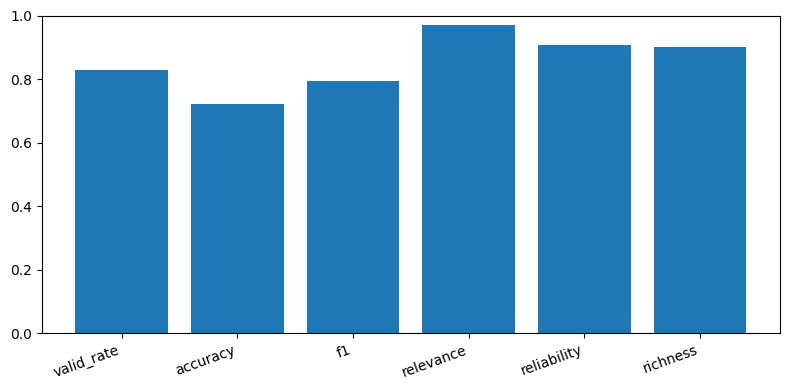

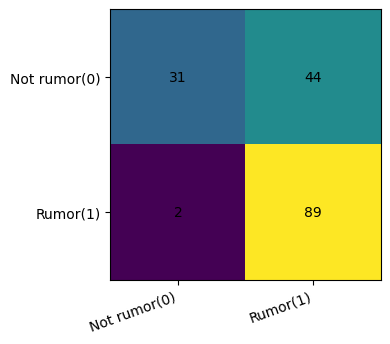

✅ Plots saved to: /content/drive/MyDrive/nlp_project/eval


In [31]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from IPython.display import display
from PIL import Image

# --- Bar chart: valid_rate, accuracy, f1, and RRR (scaled /10 to 0..1) ---
plt.figure(figsize=(8,4))
names = ["valid_rate", "accuracy", "f1", "relevance", "reliability", "richness"]
vals = [
    metrics["valid_rate"],
    metrics["accuracy"] or 0,
    metrics["f1"] or 0,
    (metrics["relevance_avg"] or 0) ,
    (metrics["reliability_avg"] or 0),
    (metrics["richness_avg"] or 0),
]
plt.bar(names, vals)
plt.ylim(0, 1.0)
plt.xticks(rotation=20, ha="right")
plt.tight_layout()

bar_path = os.path.join(EVAL_DIR, "metrics_and_rrr.png")
plt.savefig(bar_path, dpi=160)
plt.show()   # ✅ shows in Colab output

# --- Confusion matrix (only if labels parsed) ---
cm_path = os.path.join(EVAL_DIR, "confusion_matrix.png")
if gold:
    cm = confusion_matrix(gold, pred, labels=[0,1])
    plt.figure(figsize=(4,4))
    plt.imshow(cm)
    plt.xticks([0,1], ["Not rumor(0)","Rumor(1)"], rotation=20, ha="right")
    plt.yticks([0,1], ["Not rumor(0)","Rumor(1)"])
    for i in range(2):
        for j in range(2):
            plt.text(j, i, str(cm[i,j]), ha="center", va="center")
    plt.tight_layout()
    plt.savefig(cm_path, dpi=160)
    plt.show()  # ✅ shows in Colab output



print("✅ Plots saved to:", EVAL_DIR)
